In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm

import random

### Mixed-membership

We want to sample nodes that come from a mixed membership model, i.e. less good clustering. Then want to test how good our bootstraps of nodes look, and apply our KL test to test this formally.

In [3]:
# Code up a mixed membership model 
random.seed(222)

K=3
n= 300

# use our new function to make a MMSBM 
# 1May24 I added return B to the function, so I can add to the paper what B is for our example
A, largest_prob, P, B = make_MMSBM(n, K)

A = A.astype(float)
ya = UASE([A], 2)
plot_embedding(ya, n, 1, largest_prob)

In [4]:
title="MMSBM with n=300 nodes embedded with UASE into d=2 dimensions"
T=1

yadf = pd.DataFrame(ya[:, 0:2])
yadf.columns = ["Dimension {}".format(i + 1) for i in range(yadf.shape[1])]
yadf["Time"] = np.repeat([t for t in range(T)], n)
yadf["Community"] = list(largest_prob) 
yadf["Community"] = yadf["Community"].astype(str)
pad_x = (max(ya[:, 0]) - min(ya[:, 0])) / 50
pad_y = (max(ya[:, 1]) - min(ya[:, 1])) / 50
fig = px.scatter(
    yadf,
    x="Dimension 1",
    y="Dimension 2",
    color="Community",
    animation_frame="Time",
    range_x=[min(ya[:, 0]) - pad_x, max(ya[:, 0]) + pad_x],
    range_y=[min(ya[:, 1]) - pad_y, max(ya[:, 1]) + pad_y])

# fig.update_layout(title=title, title_font_size=14)
fig.update_traces(marker=dict(size=5))  # Adjust the size as desired
fig.update_layout(
    width=600,  # Adjust width as desired
    height=300,  # Adjust height as desired
)

fig.write_image("MMSBM_n300_UASE_d2.png")

fig.show()

[11052:0502/152641.376901:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


In [5]:
random.seed(222)

# Generate B matrix - this has 0.2 for all off-diagonal entries
B = np.ones((K, K)) * 0.2
comm_probs = np.linspace(0.3, 0.9, K)
np.fill_diagonal(B, comm_probs)

# make all the pi vectors (n of them)
pi_list = []
largest_prob = []
for i in range(n):
    # pi is a random probability vector of length K
    pi = np.random.dirichlet(np.ones(K)).reshape((K, 1))
    pi_list.append(pi)
    largest_prob.append(np.argmax(pi))

# (pi_list[0].T @ B @ pi_list[1])[0][0]

P = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        # this really should be pi[i] and pi[j] but since pi_i = pi_j for all i,j we don't bother
        P[i,j] = (pi_list[i].T @ B @ pi_list[j])[0][0]

A = (np.random.uniform(0, 1, n**2).reshape(n, n) < P)

A = A.astype(float)

In [6]:
pi

array([[0.6313917 ],
       [0.32619865],
       [0.04240964]])

In [7]:
B

array([[0.3, 0.2, 0.2],
       [0.2, 0.6, 0.2],
       [0.2, 0.2, 0.9]])

This isn't actually community, it is just the one probabilistically they are most likely to belong to

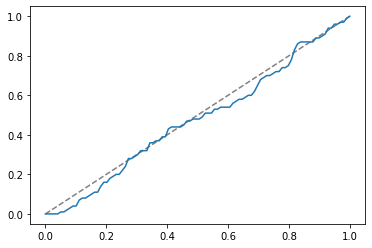

0.01

In [32]:
random.seed(12)

A_obs = A.copy()
p_vals, A_ests = test_bootstrap(A_obs, K, B=100,n_neighbors=5)
A_est = A_ests[0]

plot_power(p_vals, plot=True)

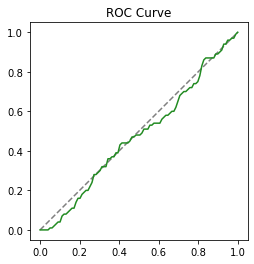

In [34]:
random.seed(12)

p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("MMSBM_n300_UASE_d2_curve.png")

plt.show()

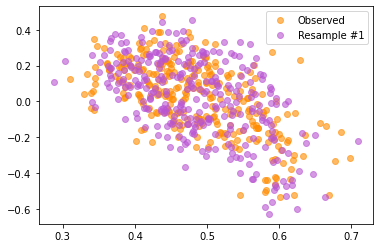

In [24]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=0.6, color='#FF8C00')
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Resample #1", alpha=0.6, color='#BA55D3')
# plt.plot(yhat_est[2, :, 0], yhat_est[2, :, 1], 'o', label="Resampled", alpha=1)

plt.savefig("MMSBM_n300_UASE_d2_obs_B1.png")

plt.legend()

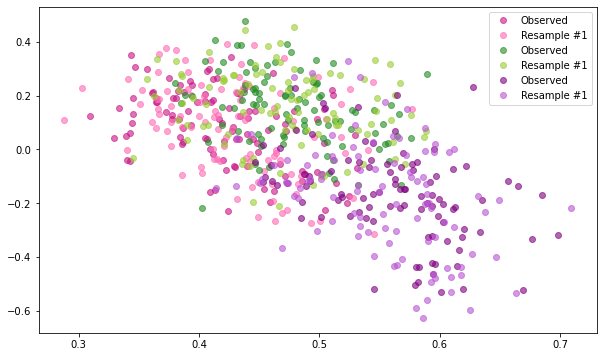

In [17]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

from matplotlib.colors import ListedColormap
cmap = plt.cm.get_cmap('Set2', K)   

# Define custom colors for the colormap
custom_colors = ['#C71585', '#228B22', '#800080', '#FF8C00']  # Example colors, you can adjust these
custom_colors2 = ['#FF69B4', '#9ACD32', '#BA55D3', '#FFC300']  

# Create a custom colormap using ListedColormap
custom_cmap = ListedColormap(custom_colors)
custom_cmap2 = ListedColormap(custom_colors2)

plt.figure(figsize=(10, 6))

for i, label in enumerate(set(largest_prob)):
    indices = [idx for idx, value in enumerate(largest_prob) if value == label]
    plt.plot(yhat_est[0, indices, 0], yhat_est[0, indices, 1], 'o', label="Observed", alpha=0.6, color=custom_cmap.colors[i])
    plt.plot(yhat_est[1, indices, 0], yhat_est[1, indices, 1], 'o', label="Resample #1", alpha=0.6, color=custom_cmap2.colors[i])

plt.legend()

In [11]:
"""comments of degree heterogeneity"""

# when you have low degree, there is less information in the graph about you (the node). 
# THis means that other nodes oyu are similar to, at least by observation in the embedding space, 
# may not be from the same community as you. Thus this is more likely nearer the origin for a 
# degree heterogenous graph.
# The test cares that your bootstraps look like the observed graph, 
# the test doesn't care for whether the boundaries between communities are clear or fuzzy. 


'comments of degree heterogeneity'